# Discrete Quantum Walks

"Quantum Walk" is an approach for developing and designing quantum algorithms. Consider it as a quantum analogy to the classical random walk. This generic technique underlies many quantum algorithms. In particular, the Grover's search algorithm can be viewed as a quantum walk.

Similarly to classical random walks, quantum walks are divided into the discrete case and the continuous one. This notebook focuses on discrete quantum walks, and is organized as follows: first, [one to one](##Classical-Random-Walks-vs.-Quantum-Walks) compares classical random walks with quantum walks via a specific example: a walk on a circle. Then, a [general quantum model](##How-to-Build-a-general-Quantum-Walk-with-Classiq) studies quantum walks and subsequently applies it to the [circle case](##Example:-Symmetric-Quantum-Walk-on-a-Circle) and to a [hypercube graph](##Example:-4D-Hypercube-with-a-Grover-Coin). 

This tutorial demonstrates the following concepts of Classiq:
* The resemblance between classical and quantum programming with Classiq.
* Classiq's built-in constructs:
    * `control`: general controlled-logic
    *  `power`: "parametric power", specified as execution parameter.
    *  `numeric quantum types`: working with signed and unsigned integers.
    *  `within_apply` : for compute/uncompute operations $U V U^{\dagger}$.
* Passing a list of `QCallables` (quantum functions).
* Parsed execution results, according to quantum variable types.


****

## Classical Random Walks Versus Quantum Walks

Specify and implement a simple example: a discrete walk on a circle, or more precisely, on a regular polygon with $2^N$ nodes (see Figure 1). The idea behind the random/quantum walk:
1. Start at some initial point, e.g., the zeroth node.
2. Flip a coin. Heads moves one step clockwise; tails moves counterclockwise.
3. Repeat steps 1-2 for a given total number of steps $T$.

<center>
<img src="https://docs.classiq.io/resources/circle_random_walk.png" style="width:30%">
<figcaption align = "middle"> Figure 1. A graph for a random walk on a circle. </figcaption>
</center>

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from classiq import *

Code a classical random walk and a discrete quantum walk side by side:

Define a function to flip a coin:
* Classical: the coin is either 0 or 1. To flip the coin, draw a random number from the set $\{0,1\}$.
* Quantum: the coin is represented by a qubit and a "flip" is defined by some unitary operation on it. Choose the Hadamard gate, which sends the $|0\rangle$ state into an equal superposition of $|0\rangle$ and $|1\rangle$.

In [2]:
def classical_coin_flip(coin):
    return np.random.randint(2)


@qfunc
def quantum_coin_flip(coin: QBit):
    H(coin)

Next, define a function for moving clockwise and counterclockwise. This operation is a modular addition by $\pm 1$.
* Classical: the position is an integer in $[-2^{N-1}, 2^{N-1}-1]$. Use basic arithmetic operations.
* Quantum: the position is an $N$-qubits state. Build an in-place modular addition by 1 (see an explanation at [the end of this notebook](#Technical-Notes)). Note that since quantum operations are reversible, you can define a counterclockwise step as the inverse of the clockwise step.

In [3]:
from classiq.qmod.symbolic import pi


# classical
def classical_step_clockwise(x, circle_size):
    return (x + 1) % circle_size


def classical_step_counterclockwise(x, circle_size):
    return (x - 1) % circle_size


# quantum
@qfunc
def quantum_step_clockwise(x: QArray):

    within_apply(
        lambda: qft(x),
        lambda: repeat(x.len, lambda i: PHASE(2 * pi * 2 ** (i) / (2**x.len), x[i])),
    )

Finally, construct a function for the full walk, iterating between flipping a coin and a single walking step based on the coin's state. Note the difference between the classical and quantum function declarations. For the quantum part you do not need to pass the circle size, as it is given by the size of the position state $x$.

In [4]:
# classical


def random_walk_circle(
    time,  # total time
    x,  # position
    circle_size,  # the size of the circle
):
    coin = 0
    for step in range(time):
        coin = classical_coin_flip(coin)
        if coin == 0:
            x = classical_step_clockwise(x, CIRCLE_SIZE)
        if coin == 1:
            x = classical_step_counterclockwise(x, CIRCLE_SIZE)
    return x


# quantum
@qfunc
def discrete_quantum_walk_circle(
    time: CInt,  # total time
    x: QArray[QBit],  # position
):
    coin = QNum("coin")
    allocate(1, coin)
    power(
        time,
        lambda: (
            quantum_coin_flip(coin),
            control(coin == 0, lambda: quantum_step_clockwise(x)),
            control(coin == 1, lambda: invert(lambda: quantum_step_clockwise(x))),
        ),
    )

Define and run a specific example, taking a circle of size $2^7$, a total time of 50 steps, and 10000 samples. 

In [5]:
CIRCLE_SIZE = 2**7
TOTAL_TIME = 50
NUM_SAMPLES = 10000

In [6]:
from classiq.execution import ExecutionPreferences
from classiq.qmod.symbolic import floor, log

# classical
final_pos = np.zeros(CIRCLE_SIZE)
for sample in range(NUM_SAMPLES):
    x = random_walk_circle(time=TOTAL_TIME, x=0, circle_size=CIRCLE_SIZE)
    final_pos[x] += 1


# quantum
@qfunc
def main(t: CInt, x: Output[QNum]):

    allocate_num(floor(log(CIRCLE_SIZE, 2)), True, 0, x)
    discrete_quantum_walk_circle(t, x)


@cfunc
def cmain():
    save({"run": sample({"t": 50})})


qmod = create_model(
    main,
    classical_execution_function=cmain,
    execution_preferences=ExecutionPreferences(num_shots=NUM_SAMPLES),
)

write_qmod(qmod, "quantum_walk_circle")
qprog = synthesize(qmod)
show(qprog)
results = execute(qprog).result()

Opening: https://platform.classiq.io/circuit/cfd073b1-0ec3-4490-b8ee-0837975e4ea0?version=0.41.0.dev39%2B79c8fd0855


<center>
<img src="https://docs.classiq.io/resources/quantum_walk_circle_circuit.png" style="width:100%">
<figcaption align = "middle"> Figure 2. The circuit for a quantum walk on a circle with $2^7$ nodes. The last three blocks are repeated `t` times. </figcaption>
</center>

Plot the probabilities of ending at each position along the circle. In both the classical and quantum cases, consider the probability of the final position after time $T=50$.

Text(0, 0.5, 'probability')

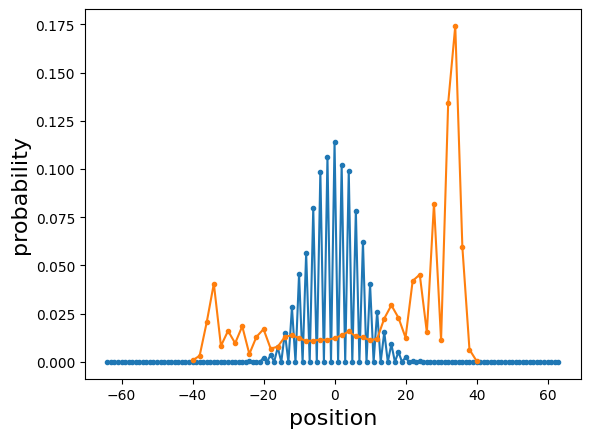

In [7]:
# classical
prob_classical = final_pos / NUM_SAMPLES
grid = (np.linspace(0, CIRCLE_SIZE - 1, CIRCLE_SIZE)).astype(int)
flipped_grid = np.append(
    grid[CIRCLE_SIZE // 2 : CIRCLE_SIZE] - CIRCLE_SIZE, grid[0 : CIRCLE_SIZE // 2]
)
flipped_prob_classical = np.append(
    prob_classical[CIRCLE_SIZE // 2 : CIRCLE_SIZE], prob_classical[0 : CIRCLE_SIZE // 2]
)

# quantum
quantum_probs = {
    sample.state["x"]: sample.shots / NUM_SAMPLES
    for sample in results[0].value.parsed_counts
}
sorted_quantum_probs = dict(sorted(quantum_probs.items()))


plt.plot(flipped_grid, flipped_prob_classical, ".-")
plt.plot(sorted_quantum_probs.keys(), sorted_quantum_probs.values(), ".-")
plt.xlabel("position", fontsize=16)
plt.ylabel("probability", fontsize=16)

There is a clear difference between the two distributions. The classical distribution is symmetric around the zero position, whereas the quantum example is asymmetric with a peak far from 0. This is a small example of the different behaviors of classical random walks and quantum walks. More details and examples are in Ref. [[1](#review)].

## How to Build a General Quantum Walk with Classiq

Define a quantum function for a discrete quantum walk. The arguments of the function:
* `time`: an integer for the number of walking steps.
* `coin_flip_qfunc`: the quantum function for "flipping" the coin.
* `walks_qfuncs`: a list of quantum functions for all possible transitions at a given point.
* `coin_state`: the quantum state of the coin.

In [8]:
from classiq.qmod.symbolic import pi


@qfunc
def discrete_quantum_walk(
    time: CInt,
    coin_flip_qfunc: QCallable[QNum],
    walks_qfuncs: QCallableList,
    coin_state: QNum,
):

    power(
        time,
        lambda: (
            coin_flip_qfunc(coin_state),
            repeat(
                walks_qfuncs.len,
                lambda i: control(coin_state == i, lambda: walks_qfuncs[i]()),
            ),
        ),
    )

## Example: Symmetric Quantum Walk on a Circle

As a first example, consider the circle geometry above, implemented with the generic definition but with a different initial condition for the coin. Take $\frac{1}{\sqrt{2}}(|0\rangle +i |1\rangle)$ instead of $|0\rangle$. This state is a balanced initial condition for the coin (see Ref. [[1](#review)]) and can be prepared by applying an H gate followed by an S gate.

In [9]:
from classiq.execution import ExecutionPreferences

CIRCLE_SIZE = 2**7
NUM_SHOTS = 1e4


@qfunc
def main(t: CInt, x: Output[QNum]):

    coin = QBit("coin")
    allocate_num(floor(log(CIRCLE_SIZE, 2)), True, 0, x)
    allocate(1, coin)
    H(coin)
    S(coin)
    discrete_quantum_walk(
        t,
        lambda coin: H(coin),
        [
            lambda: quantum_step_clockwise(x),
            lambda: invert(lambda: quantum_step_clockwise(x)),
        ],
        coin,
    )


@cfunc
def cmain():
    save({"run1": sample({"t": 50})})


qmod = create_model(
    main,
    classical_execution_function=cmain,
    execution_preferences=ExecutionPreferences(num_shots=NUM_SHOTS),
)

Now that the model is defined, you can synthesize, execute, and plot the outcome probability:

Opening: https://platform.classiq.io/circuit/a430e208-f365-47e7-a7fc-0b0b99fc4743?version=0.41.0.dev39%2B79c8fd0855


Text(0, 0.5, 'probability')

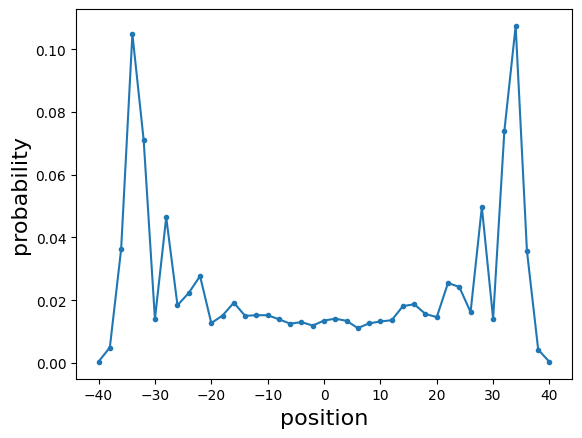

In [10]:
qprog = synthesize(qmod)
write_qmod(qmod, "quantum_walk_circle_balanced_coin")
show(qprog)
results = execute(qprog).result()
quantum_probs = {
    sample.state["x"]: sample.shots / NUM_SAMPLES
    for sample in results[0].value.parsed_counts
}
sorted_quantum_probs = dict(sorted(quantum_probs.items()))

plt.plot(sorted_quantum_probs.keys(), sorted_quantum_probs.values(), ".-")
plt.xlabel("position", fontsize=16)
plt.ylabel("probability", fontsize=16)

The distribution is symmetric. Clearly, the distribution of a quantum walk on a circle depends on the initial condition for the coin. This is another example of the peculiar behavior of quantum walks compared to classical random walks.

## Example: 4D Hypercube with a Grover Coin

Next, consider a hypercube graph (see Figure 3). The quantum walk on a hypercube shows completely different behavior compared to its classical counterpart. One striking difference refers to the hitting time, which is the time it takes to reach node $v$ starting from an initial node $u$. In particular, an interesting question is the hitting time between one corner of the hypercube "000..0" to the opposite one "111...1". Ref. [[2](#hypercube)]) shows that the hitting time for the hypercube in quantum walks is *exponentially faster* than the analog quantity in classical random walks. The rigorous definition of the "hitting time" in the quantum case is nontrivial, and different definitions are relevant. This notebook does not use the exact definition, but simply demonstrates a specific result, highlighting the result of Ref. [[2](#hypercube)]. 

Define $P_{\rm corner}(T)$ as the probability of measuring the walker at the opposite corner $|2^{N}-1\rangle$ after $T$ steps, starting at position $|0\rangle$ at time 0. Examine this quantity for the quantum and the classical case.

<center>
<img src="https://docs.classiq.io/resources/hypercube_random_walk.png" style="width:50%">
<figcaption align = "middle"> Figure 3. A graph for a random walk on a 3D hypercube. </figcaption>
</center>

Define a model for quantum walk on a hypercube. Two nodes in the hypercube are connected to each other if their Hamming distance is 1. Thus, a step along a hypercube is given by moving "1 Hamming distance away". For a $d$-dimentional hypercube, at each node there are $d$ possible directions to move. Each of them is given by applying a bit flip on one of the bits. In the quantum case, this is obtained by applying an X gate on one of the $N$ qubits.

For the coin operator, take the "Grover diffuser" function. This choice refers to a symmetric quantum walk [[1](#review)]. The Grover diffuser operator is a reflection around a given state $|\psi\rangle$:
$$
G = I-2 |\psi\rangle\langle\psi|,
$$
where I is the identity matrix. In the $N$-dimensional hypercube each node is connected to $N$ nodes, thus, the coin state should include $N$ different states. Therefore, the coin is represented by a quantum variable of size $\lceil \log_2(N)\rceil$, and the Grover diffuser is defined with
$$
|\psi\rangle = \frac{1}{\sqrt{N}}\sum^{N-1}_{i=0} |i\rangle.
$$

Build the model using the `grover_diffuser` function from the Classiq open library.

In [11]:
@qfunc
def moving_one_hamming_dist(pos: CInt, x: QArray[QBit]):
    X(x[pos])

In [12]:
from classiq.execution import ExecutionPreferences
from classiq.qmod.symbolic import ceiling

SPACE_SIZE = 4
NUM_SHOTS = 1e4

# if the space size is not 2^r, pad the coin state with zeros
reduced_coin_state = [1 / SPACE_SIZE] * SPACE_SIZE + [0] * int(
    2 ** np.ceil(np.log2(SPACE_SIZE)) - SPACE_SIZE
)


@qfunc
def main(
    t: CInt,
    x: Output[QArray[QBit]],
):

    # start at the zero state location
    allocate(SPACE_SIZE, x)

    # start with equal superposition for the relevant states.
    coin = QArray("coin")
    prepare_state(reduced_coin_state, 0.0, coin)
    discrete_quantum_walk(
        t,
        lambda coin: grover_diffuser(
            lambda coin: inplace_prepare_state(reduced_coin_state, 0.0, coin), coin
        ),
        [
            lambda: moving_one_hamming_dist(0, x),
            lambda: moving_one_hamming_dist(1, x),
            lambda: moving_one_hamming_dist(2, x),
            lambda: moving_one_hamming_dist(3, x),
        ],
        coin,
    )


@cfunc
def cmain():
    save({"run": sample({"t": 4})})


qmod = create_model(
    main,
    classical_execution_function=cmain,
    execution_preferences=ExecutionPreferences(num_shots=NUM_SHOTS),
    constraints=Constraints(optimization_parameter="width"),
)

write_qmod(qmod, "quantum_walk_hypercube")

In [13]:
qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/c674bb1e-ca9f-4d56-b2a1-e74797d25ec2?version=0.41.0.dev39%2B79c8fd0855


<center>
<img src="https://docs.classiq.io/resources/quantum_walk_hypercube_circuit.png" style="width:100%">
<figcaption align = "middle"> Figure 4. The circuit for a quantum walk on a 4D cube with a Grover coin. The last two blocks are repeated `t` times. </figcaption>
</center>

In [14]:
results = execute(qprog).result()

In [15]:
print(
    "The probability to reach the opposite corner:",
    results[0].value.counts.get("1" * SPACE_SIZE, 0) / NUM_SHOTS,
)

The probability to reach the opposite corner: 0.56


We found that at $T=4$ the probability to measure the walker at the opposite corner is larger than $1/2$. We can check an analogous question in the classical random walk, where the distribution is taken over an ensemble of independent experiments):

In [16]:
initial_point = 0
final_point = dict()

for sample in range(NUM_SAMPLES):
    coin_state = np.random.randint(SPACE_SIZE)
    for k in range(SPACE_SIZE):
        if coin_state == k:
            temp_point = initial_point ^ 2**k
            initial_point = temp_point
    final_point[initial_point] = final_point.get(initial_point, 0) + 1

print(
    "The probability to reach the opposite corner in the classical case:",
    final_point.get(2**SPACE_SIZE - 1, 0) / NUM_SAMPLES,
)

The probability to reach the opposite corner in the classical case: 0.0658


For the classical analogous case, the probability is much lower. This is a manifestation of the fact that the hitting time in a hypercube is exponentially shorter in quantum walks, in comparison to classical random walks.

## Technical Notes

### QFT modular adder

Below we explain the `quantum_step_clockwise` function defined for the quantum walk on a circle. The unitary matrix that represents walking on a circle operates as follows:
$$
U_{+}|i\rangle =
\left\{
\begin{array}{l l}
 |i+1\rangle & {\text{if  } } i\neq 2^{N-1}\\
 |0\rangle & {\text{if  } } i = 2^{N-1}
\end{array}
\right.
$$
In a matrix form this is simply the matrix
$$
U_+ = 
\begin{pmatrix}
	 0 & 1 & 0 & \cdots & 0 & 0 \\
	 0 & 0 & 1 & 0 & \cdots & 0 \\
	 0 & \ddots &\ddots & \ddots & \cdots & 0 \\
	 \vdots & \ddots & \ddots & \ddots& \ddots & \vdots \\
	 0 & \ddots & \ddots & 0& 0 & 1\\
	 1 & 0 & 0 & \cdots & 0 & 0
\end{pmatrix}.
$$
In Fourier space this matrix is diagonal, namely, the Fourier matrix $\mathcal{FT} $ diagonalizes it. Moreover, the diagonal entries forms a goemetric series:
$$
U_+  = \mathcal{FT} \cdot \begin{pmatrix}
	\alpha^0 &  0 & \cdots& \cdots  & 0 \\
	 0 & \alpha^1 & 0 &  \cdots & 0 \\
	 0 & 0 &\ddots & \cdots & 0 \\
	 0 & 0 &\cdots & \alpha^{2^N-2} & 0 \\
	 0 & \cdots & 0 & \cdots & \alpha^{2^N-1}
\end{pmatrix} \cdot \mathcal{FT}^{\dagger},
$$
with $\alpha=e^{2\pi i /2^N }$. We can implement both the $\mathcal{FT}$ matrix and the diagonal matrix efficiently on a quantum computer, the former by a QFT and the latter by applying a series of $N$ RZ rotations.

<a id='review'>[1]</a>: [Kempe, J. "Quantum random walks: an introductory overview." Contemporary Physics 44, 307 (2003)](https://arxiv.org/abs/quant-ph/0303081).

<a id='hypercube'>[2]</a>: [Kempe, J. "Discrete quantum walks hit exponentially faster." Probability theory and related fields 133, 215 (2005)](https://arxiv.org/abs/quant-ph/0205083).